In [1]:
%load_ext autoreload
%autoreload 1
%aimport util_csv
%aimport util_image
%aimport runner

Using TensorFlow backend.


## Imports

In [2]:
from runner import *
from util_image import *
from util_csv import NewFileName
from runner import DataBase as DB
from Timer import Timer 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
def compute_hist(dataset, bins=300, verbose=True, top=0, returnSortedInds=False):

    def vprint(string): 
        if verbose: print(string)
    
    '''
        Computes data histogram.
        Returns: 
            dhist  : bin counts
            dbins  : bin boundaries
            sortInd: bin count indices in ascending order
    '''
    returnTopKInds = top > 0
    dhist, dbins = np.histogram(dataset, bins=bins)
    sortInd = (-1*dhist).argsort()
    
    vprint("{:5s} :          Ranges".format("Count"))
    topK = []
    for i in range(max(0,top)): 
        ind = sortInd[i] #[-(i+1)]
        cnt = dhist[ind]
        vprint("{:5d} : [ {: 5.5f}, {: 5.5f} ]".format(cnt, dbins[ind], dbins[ind+1]))
        topK.append([cnt, dbins[ind], dbins[ind+1]])
    
    ret = (dhist, dbins)    
    if returnTopKInds: ret = ret + (topK, )
    if returnSortedInds: ret = ret + (sortInd, )
    return ret
    
def show_data_distribution(dhist, dbins):
    ax = plt.plot(dbins[:-1],dhist)
    plt.grid('on')
    plt.show()

### Data Input

---------------------------------------------------------------
elapsed time: 16.140 secs
---------------------------------------------------------------
Count :          Ranges


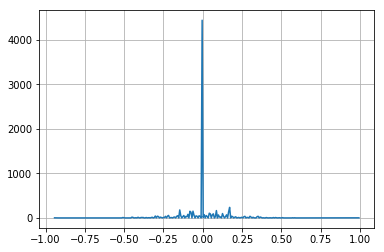

,steer,gas,brake,speed
count,8036.000000,8036.000000,8036.000000,8036.000000
mean,0.004070,0.869660,0.001970,28.169839
std,0.128840,0.301326,0.036565,6.149327
min,-0.942695,0.000000,0.000000,0.502490
25%,0.000000,0.985533,0.000000,30.183093
50%,0.000000,0.985533,0.000000,30.186400
75%,0.000000,0.985533,0.000000,30.186640
max,1.000000,0.985533,1.000000,30.709360


In [4]:
data_path =  'data/org'

data = Timer.run(lambda :DB.CreateFromFile(data_path))
data_path = data.params[BaseDir]

show_data_distribution(*compute_hist(data.steer))
data.describe()


## Pre-Process

Take 5% of the most occuring data

Count :          Ranges
 4440 : [ -0.00373,  0.00275 ]
  237 : [  0.17112,  0.17759 ]
  179 : [ -0.14619, -0.13971 ]
len BA = 4440, n = 3885, maxInds = 8035
Count :          Ranges


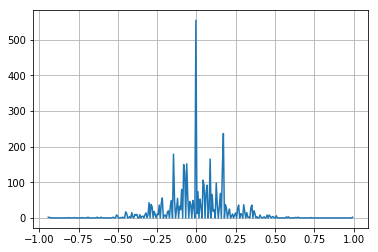

In [5]:
from random import sample

_,_,rngs = compute_hist(data.steer, top=3)

inds_within_range = (data.steer >= rngs[0][1]) & (data.steer <= rngs[0][2]) 
dataSmall = data.grab(inds_within_range,pcent=0.125)
show_data_distribution(*compute_hist(dataSmall.steer))

## Add Flipped Images

Count :          Ranges


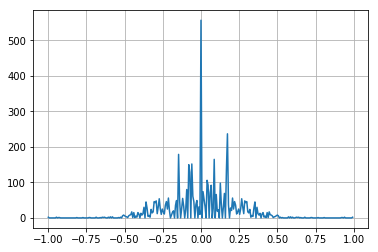

Count :          Ranges


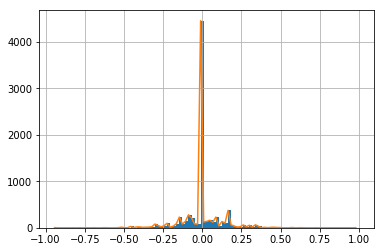

Count :          Ranges


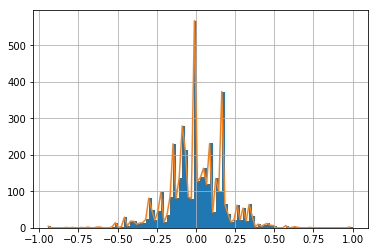

Count :          Ranges


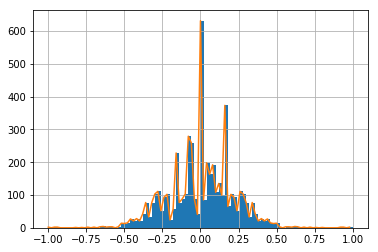

In [6]:
flipped = AddFlippedImages(dataSmall, skip_range=(-0.2, 0.2))
show_data_distribution(*compute_hist(flipped.steer, bins=300))

for d in [data.steer, dataSmall.steer, flipped.steer]:
    bins = 100
    d.hist(bins=bins)
    show_data_distribution(*compute_hist(d, bins=bins))


## Add Side Imges

Count :          Ranges


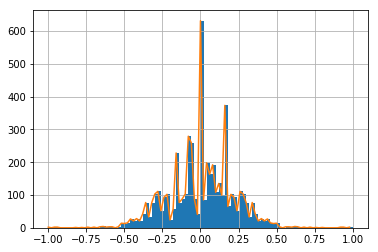

Count :          Ranges


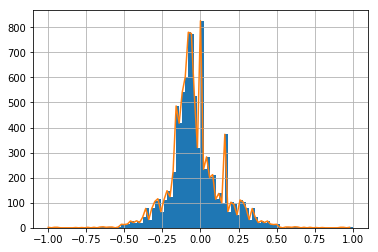

In [7]:
flipped.params = dataSmall.params
# def AddSideImage(data, left_steer=(0.2,0.05), right_steer=(-0.2,0.05), basedir=None):

side = AddSideImage(flipped, left_steer=(0.2,0.05), right_steer=(-0.2,0.05))

len(side), len(flipped), len(dataSmall), len(data)

for d in [flipped.steer, side.steer]:
    bins = 100
    d.hist(bins=bins)
    show_data_distribution(*compute_hist(d, bins=bins))

## Train

In [8]:
from os.path import join, abspath, basename, dirname, exists, splitext, isdir, isfile
import os
import json
import sys
def save_logs(res, logfile):
    with open(logfile, 'w') as fp:
        fp.write("Model Summary\n")
        oldstdout = sys.stdout
        sys.stdout = fp
        res.model.summary()
        fp.flush()
        sys.stdout = oldstdout
        fp.write("\n\n\n")
        json.dump(res.params, fp, indent=4)
        fp.write("\n\n\n")        
        fp.write("History\n")
        i = 1
        fp.write('Epoch:    {:5s} \t{:5s} \t{:5s} \t{:5s} \n'.format(*tuple(res.history.keys())))
        for cc in zip(*res.history.values()):
            fp.write('{:2d}: \t{:5.5f} \t{:5.5f} \t{:5.5f} \t{:5.5f} \n'.format(i, *cc))
            i+=1
            
def save_result(res, path):
    path = splitext(path)[0]
    path = NewFileName(path)
    name = basename(path)
    os.makedirs(path)

    logfile = join(path, 'log.txt')
    arch    = join(path, 'arch.json')
    weights = join(path, 'weights.h5')
    full    = join(path, 'model.h5')

    save_logs(res, logfile)
    res.model.save_weights(weights)
    res.model.save(full)

    with open(arch,'w') as fp: fp.write(res.model.to_json())
        
    return (logfile, arch, weights, full)

In [9]:
root = 'models/model_nv1.h5'
path=NewFileName(root)
tr = Timer.run(lambda: NVidia1(side))
res = Timer.run(lambda: tr.train(batch_size=128, epoch=25, path=path))
save_result(res, root)
print("Model Saved At: " + path)


# root = 'models/model_nv2.h5'
# path=NewFileName(root)
# tr = Timer.run(lambda: NVidia2(side))
# res = Timer.run(lambda: tr.train(batch_size=128, epoch=25, path=path))
# save_result(res, root)
# print("Model Saved At: " + path)


# path=NewFileName('models/model_nf.h5')
# tr = Timer.run(lambda:NVidia(dataSmall))
# res = Timer.run(lambda: tr.train(epoch=15, verbose=1, path=path))

# print("Model Saved At: " + path)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_1 (Cropping2D)    (None, 80, 320, 3)        0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 80, 320, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 38, 158, 12)       912       
_________________________________________________________________
elu_1 (ELU)                  (None, 38, 158, 12)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 77, 13)        3913      
_________________________________________________________________
elu_2 (ELU)                  (None, 17, 77, 13)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 38, 13)         0         
__________

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/models.py:837: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 7310 samples, validate on 1828 samples
Epoch 1/25
7310/7310 [==============================] - 13s - loss: 0.7223 - acc: 0.0646 - val_loss: 0.0198 - val_acc: 0.0000e+00